#### This notebook contains my solution explanation with minimal code for the Entity Resolution problem (https://veridion.com/engineering-challenges/).


First of all, I have to take a look at the data, to see what are the missing percentages and to identify the key features that I can use to identify the duplicates.

c:\Users\sampe\OneDrive\Desktop\projects\EntityResolution\src\CompaniesDataAnalyzer.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=filtered_columns.values, y=filtered_columns.index, palette="viridis")


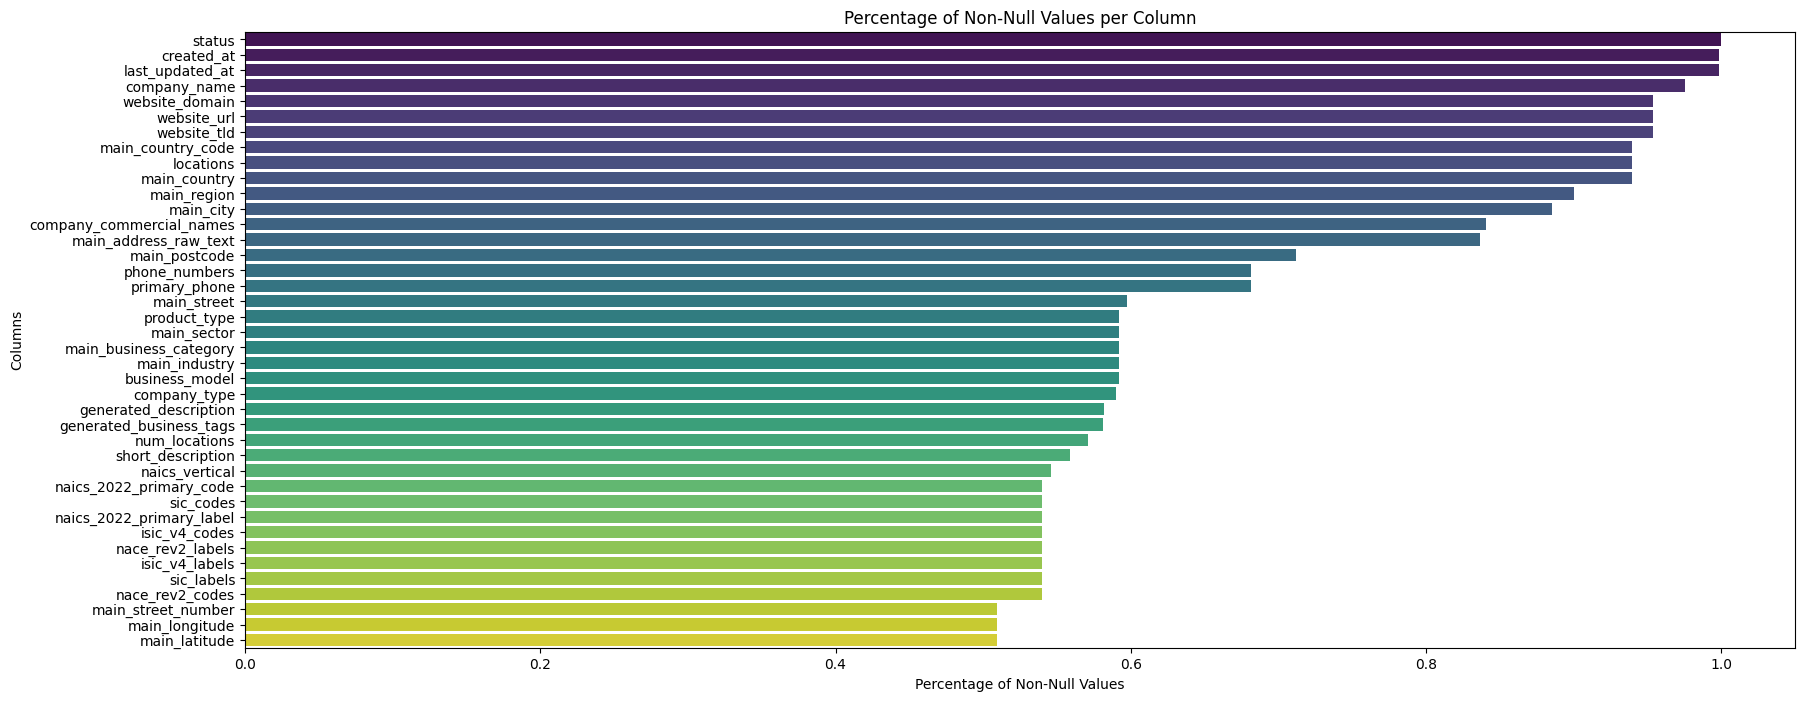

In [46]:
from src.CompaniesDataAnalyzer import CompaniesDataAnalyzer

file_path = "input/veridion_entity_resolution_challenge.snappy.parquet"
analyzer = CompaniesDataAnalyzer(file_path)
analyzer.load_data()
original_data = analyzer.df.copy()

# plot the values that are not null in more than 50% of data
analyzer.plot_values(min_present_ratio=0.5)

I chose to plot only columns with more than 50% of non-null values, because I will have to compare them with each other, and if they are too sparse, it will be hard/inefficient to find duplicates.

Now, I will have to select the features that I will use to identify the duplicates, and these will be:
- **company_name**
- **website_domain**, if missing I will try to use **website_url** to fill it
- **primary_phone**, if missing I will try to use **phone_numbers** to fill it
- **main_street** + **main_street_number** + **main_country** + **main_region** + **main_city**
- **main_industry**

<br>

Why I used these features?
- **company_name**: While not always unique due to variations and errors, it's a valuable feature after appropriate cleaning.
- **website_domain**: Considered a strong unique identifier. Missing values were addressed by attempting to populate them from **website_url** using `tldrextract` library.
- **primary_phone**: Another potential unique identifier. Missing values were addressed by attempting to populate them from **phone_numbers**.
- A combination of **main_street**, **main_street_number**, **main_country**, **main_region**, and **main_city**. This provides location-based context
- **main_industry**: Used as a supplementary filter to distinguish companies in different sectors.

### ⚠️ Important Observation:
Theoretically, I can obtain all the information I need by using **website_url** to get the web HTML and then using a web scraping library to extract the information I need. However, this approach is time-consuming and inefficient, so I will not use it. Instead, I will use the information that is already available in the dataset to try to fill the missing values. This way, a balance between efficiency and accuracy is achieved.

In [47]:
analyzer.set_key_fields(["company_name", "website_domain", "primary_phone", "main_street", "main_postcode",
								"main_street_number", "main_country", "main_city", "main_region", "main_industry"])
analyzer.handle_missing_values()

analyzer.print_key_fields(num=5)

,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
0,Owens Liquors,owensliquors.com,+18433140354,Ocean Highway,29585,13707,United States,Pawleys Island,South Carolina,Beverages
1,Club Tarneit,clubtarneit.com.au,None,None,3029,None,Australia,City Of Wyndham,Victoria,Pubs & Bars
2,AAA Auto Otrokovice Zlín,aaaauto.cz,+420800400450,Zlínská,765 02,260,Czechia,Otrokovice,Zlín,Automobile Dealers & Manufacturers
3,Gisinger GmbH,None,None,Berauer Straße,79777,19,Germany,Ühlingen-Birkendorf,Baden-Württemberg,None
4,Kasana Life,None,+19174887460,None,06759,None,United States,Litchfield,Connecticut,None


The next step involves cleaning string data such as `company_name` and `main_street`. These fields can contain:

*   Non-ASCII characters
*   Inconsistencies between upper and lower case
*   Legal suffixes

My goal is not to keep the data intact, but to make the comparison between them consistent. This standardization step helps improve matching accuracy by reducing variations.

In [48]:
analyzer.clean_data()
analyzer.print_key_fields(num=5)

,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
0,owens liquors,owensliquors.com,+18433140354,ocean highway,29585,13707,united states,pawleys island,south carolina,beverages
1,club tarneit,clubtarneit.com.au,None,,3029,None,australia,city of wyndham,victoria,pubs bars
2,aaa auto otrokovice zlin,aaaauto.cz,+420800400450,zlinska,765 02,260,czechia,otrokovice,zlin,automobile dealers manufacturers
3,gisinger,None,None,berauer strasse,79777,19,germany,uhlingenbirkendorf,badenwurttemberg,
4,kasana life,None,+19174887460,,06759,None,united states,litchfield,connecticut,


Looks pretty good to me. 

To avoid the case when I have to compare every features of a company with all of the other companies **O(n^2)**, I will use blocking strategy. I will group the companies by:
1.  `website_domain`: Companies sharing the same domain are grouped together.
2.  `company_name`: Companies with similar names are grouped together.
3.  `primary_phone`: Companies with the same phone number are grouped together.

By grouping data this way, I will be able to reduce the number of comparisons I have to make.

I am creating blocks across multiple categories, because no single field above has 100% coverage.

For example: 
- Record 1: {name: "IBM Corp", domain: "ibm.com", phone: "1234567890", location: "NY, USA"}
- Record 2: {name: "International Business Machines", domain: missing, phone: "1234567890", location: "New York, USA"}
With single-key blocking:

**Domain-only** blocking would miss this match

**Name-only** blocking might miss it due to different formats

**Phone** blocking would catch it

In [49]:
from src.CompaniesEntityResolution import CompaniesEntityResolution

companies_er = CompaniesEntityResolution(analyzer.df, analyzer.key_fields)

print("Maximum number of comparisons --> O(n^2): " + str(len(analyzer.df) * (len(analyzer.df) - 1) // 2))

candidate_pairs = companies_er.create_blocks().generate_candidate_pairs()
for i, (index1, index2) in enumerate(candidate_pairs[:5]):
	print(f"Group {i+1}:")
	display(analyzer.df[analyzer.key_fields].loc[[index1, index2]])

Maximum number of comparisons --> O(n^2): 559300735
domain_block: 6614 unique blocks
phone_block: 12523 unique blocks
name_block: 15657 unique blocks
Group 1:


,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
25769,equmeniakyrkan i sodra nissadalen,equmeniakyrkan.se,+46732689893,,313 94,None,sweden,halmstads kommun,halland county,churches
30086,equmeniakyrkan,equmeniakyrkan.se,None,,None,None,sweden,,,


Group 2:


,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
15822,original royalty,originalroyalty.com,None,,None,None,,,,
31622,elkanah,originalroyalty.com,None,,None,None,,,,entertainment


Group 3:


,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
3433,persimmon homes,persimmonhomes.com,None,bridge lane,KY16 0FQ,2,united kingdom,st andrews,scotland,general contractors heavy construction
8826,persimmon homes hardys gate,persimmonhomes.com,+441612582784,dumers lane,M26 2QJ,None,united kingdom,manchester,england,general contractors heavy construction


Group 4:


,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
5913,towa denki co ltd miyazaki office,towadenki.co.jp,+81985653339,Gong Qi intaZuo Tu Yuan Xian,880-0856,49-1,japan,miyazaki,miyazaki prefecture,
31006,towa denki,towadenki.co.jp,+81335041511,road no 8,71007,33,vietnam,ho chi minh city saigon,ho chi minh city,building material


Group 5:


,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
23225,showa enterprise co ltd niigata branch,showa-sc.co.jp,None,,950-0872,None,japan,niigata,niigata prefecture,
32996,showakigyo co,showa-sc.co.jp,+81263257445,,390-0851,None,japan,matsumoto,nagano prefecture,building material


### ⚠️ Important Observation:
For some groups, companies have the same web domain, but slightly different names and different physical addresses. This is a case where a company has multiple locations/branches. For these cases, I will merge the companies as a single entity, because:
- **Shared web domain**: The same web domain strongly indicates that these records belong to the same parent organization, as companies typically use a single domain for all branches.
- **Operational reality**: Companies with multiple locations often have distinct addresses and phone numbers for operational purposes, but they still represent the same entity at a higher level.
- **Purpose of this solution**: My goal is to identify unique companies, not necessarily to distinguish between branches or locations.

It's time to compare the records in each block. I will use the following string similarity measures:
- For **company_name**: Longest Common Subsequence (LCS) similarity
- For **website_domain**: Jaro-Winkler similarity
- For **primary_phone**: Exact match (binary similarity: 1 if equal, 0 otherwise)
- For **main_street**: Jaro-Winkler similarity
- For **main_street_number**: Jaro-Winkler similarity
- For **main_country**: Jaro-Winkler similarity
- For **main_region**: Jaro-Winkler similarity
- For **main_city**: Jaro-Winkler similarity
- For **main_postcode**: Jaro-Winkler similarity
- For **main_industry**: Jaro-Winkler similarity

`LCS` - Measures the similarity between two strings based on their longest common subsequence. <br>
`Jaro-Winkler` - A string edit distance metric that favors strings with common prefixes.

In [50]:
import pandas as pd

similarity_df: pd.DataFrame = companies_er.compare_candidate_pairs(candidate_pairs)


Let's print a couple of records along with their similarity scores to see how they look like.

In [51]:
display(similarity_df.tail(2))

idxs1, idxs2 = similarity_df[['idx1', 'idx2']].tail(2).values.T
for (idx1, idx2) in zip(idxs1, idxs2):
	print(f"Group:")
	display(analyzer.df[analyzer.key_fields].loc[[idx1, idx2]])

,idx1,idx2,name_similarity,domain_similarity,phone_similarity,location_similarity,industry_similarity
115889,11902,29243,0.510638,1.0,0.0,0.000000,0.611991
115890,2711,23208,1.000000,1.0,1.0,0.660535,0.000000


Group:


,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
11902,crystallines container services,thecrystallines.com,+914224366805,,641001,None,india,coimbatore,tamil nadu,freight transport
29243,the crystallines,thecrystallines.com,None,,None,None,,,,entertainment


Group:


,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
2711,conquest contractors,cqcontractors.com,+14152060524,toland street,94124,290,united states,san francisco,california,
23208,conquest contractors,cqcontractors.com,+14152060524,mitten road,94010,880,united states,burlingame,california,general contractors heavy construction


Cool, looks pretty good to me.



I have to define a set of rules to determine if two records are duplicates or not. Those rules are:
1) If the **website_domain** is almost the same AND **name** similarity is almost the same. 
2) If primary phone is the same, AND **name** similarity is almost the same.
3) If **name** is exactly the same, AND **location** similarity is almost the same AND **industry** similarity is almost the same. 

These rules were made based on the fields that I have selected for the blocking strategy     (website_domain, company_name, primary_phone).

In [52]:
similarity_df = companies_er.classify_pairs(similarity_df)

After applied the rules above, I have obtained `true_matches` and `false_matches`.
For `false_matches` I identified following interesting example:
- **Group 1**:
	- **Record 1**: {name: fadie moritsune store, domain: fadie.com, phone: +81939638190, etc}
	- **Record 2**: {name: kafefadiyamaguchiten, domain: fadie.com, phone: +81839282225, etc}

Even though they have the same **domain**, their **names** are completely different.
Maybe there is some sort of data error. In which case, I will NOT merge them.

In [53]:
true_matches = similarity_df[similarity_df['is_match'] == True].tail(2)

false_matches = similarity_df[similarity_df['is_match'] == False].tail(2)
for _, row in pd.concat([true_matches, false_matches]).iterrows():
	idx1, idx2 = row['idx1'], row['idx2']
	print(f"Pair (idx1: {idx1}, idx2: {idx2}) - is_match: {row['is_match']}")
	display(analyzer.df[analyzer.key_fields].loc[[idx1, idx2]])


Pair (idx1: 11902, idx2: 29243) - is_match: True


,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
11902,crystallines container services,thecrystallines.com,+914224366805,,641001,None,india,coimbatore,tamil nadu,freight transport
29243,the crystallines,thecrystallines.com,None,,None,None,,,,entertainment


Pair (idx1: 2711, idx2: 23208) - is_match: True


,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
2711,conquest contractors,cqcontractors.com,+14152060524,toland street,94124,290,united states,san francisco,california,
23208,conquest contractors,cqcontractors.com,+14152060524,mitten road,94010,880,united states,burlingame,california,general contractors heavy construction


Pair (idx1: 7009, idx2: 23877) - is_match: False


,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
7009,fadie moritsune store,fadie.com,+81939638190,kitagata bypass,802-0974,2,japan,kitakyushu,fukuoka prefecture,pubs bars
23877,kafefadiyamaguchiten,fadie.com,+81839282225,yamaguchi bypass,753-0815,5,japan,yamaguchi,yamaguchi prefecture,pubs bars


Pair (idx1: 6195, idx2: 8842) - is_match: False


,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
6195,georg stiefel heizung luftung sanitar,shk.de,+496131670297,frauenlobstrasse,55118,84,germany,mainz,rhinelandpalatinate,finishing contractors
8842,probst und dahm,shk.de,+4926283444,mainzer strasse,56321,37,germany,rhens,rhinelandpalatinate,general contractors heavy construction


The final step is to group matched records into clusters, where each cluster represents a unique company. I used a graph-based approach to ensure **transitivity**: if record A matches B, and B matches C, then A, B, and C are in the same cluster.

Each record is assigned a **cluster ID** based on its connected component. Unmatched records receive their own unique ID.

In [54]:
index_to_cluster = companies_er.create_company_clusters(similarity_df)
analyzer.df['cluster_id'] = analyzer.df.index.map(lambda idx: index_to_cluster.get(idx, -1))
original_data['cluster_id'] = analyzer.df.index.map(lambda idx: index_to_cluster.get(idx, -1))

# cluster statistics
cluster_sizes = analyzer.df['cluster_id'].value_counts()
print(f"Found {len(cluster_sizes)} unique companies")
print(f"Original dataset had {len(analyzer.df)} records")
print(f"Reduction rate: {(1 - len(cluster_sizes)/len(analyzer.df))*100:.2f}%")

print(f"Smallest cluster size: {cluster_sizes.min()}")
print(f"Largest cluster size: {cluster_sizes.max()}")
print(f"Average cluster size: {cluster_sizes.mean():.2f}")

cluster_id_to_display = 12 # Display one of the clusters
print(f"\nDisplaying records for cluster ID: {cluster_id_to_display}")
display(analyzer.df[analyzer.df['cluster_id'] == cluster_id_to_display][analyzer.key_fields].head(8))


Found 7710 unique companies
Original dataset had 33446 records
Reduction rate: 76.95%
Smallest cluster size: 1
Largest cluster size: 49
Average cluster size: 4.34

Displaying records for cluster ID: 12


,company_name,website_domain,primary_phone,main_street,main_postcode,main_street_number,main_country,main_city,main_region,main_industry
47,regionalni sklad inter cars,intercars.cz,+420604907955,3547,751 35,1763,czechia,lipnik nad becvou,olomouc,
1797,inter cars,intercars.cz,+420727870882,druzstevni,669 02,3970/30,czechia,znojmo,south moravia,auto parts
2790,inter cars ceska republika,intercars.cz,None,,None,None,czechia,prague,prague,auto parts
3195,inter cars,intercars.cz,+420474470301,dubska,415 01,1635,czechia,teplice,usti nad labem,auto parts
5863,inter cars,intercars.cz,+420725523512,generala svobody,538 34,339,czechia,rosice,pardubice,auto parts
7635,inter cars,intercars.cz,+420388320450,okruzni,370 10,2615,czechia,,south bohemia,auto parts
8694,inter cars,intercars.cz,+420724586444,horeni,400 11,2472/14,czechia,usti nad labem,usti nad labem,auto parts
9055,inter cars,intercars.cz,+420605053172,revolucni,250 92,1114,czechia,,central bohemia,auto parts


In [55]:
unique_companies = companies_er.create_deduplicated_dataset(original_data)

print(f"Original dataset: {len(analyzer.df)} records")
print(f"Deduplicated dataset: {len(unique_companies)} records")
print(f"Reduction: {len(analyzer.df) - len(unique_companies)} records ({(1 - len(unique_companies)/len(analyzer.df))*100:.2f}%)")

Original dataset: 33446 records
Deduplicated dataset: 7710 records
Reduction: 25736 records (76.95%)


It's time to save the results. 

- **Deduplicated Data**: The `unique_companies` DataFrame, containing one representative record per cluster, is saved to a Parquet file (`output/unique_companies.snappy.parquet`).
- **Cluster Mappings**: The `index_to_cluster` dictionary, which maps original record indices to cluster IDs, is saved to a JSON file (`output/company_clusters.json`). Each cluster contains a list of indices representing the row in the original dataset.


In [56]:
unique_companies.to_parquet('output/unique_companies.snappy.parquet', compression='snappy')

companies_er.save_cluster_mappings(index_to_cluster, 'output/company_clusters.json')


Saved cluster mappings to c:\Users\sampe\OneDrive\Desktop\projects\EntityResolution\output\company_clusters.json
